# IMDb Prediction - Exploratory Data Analysis

O IMDb (Internet Movie Database) é um portal online responsável por uma base de dados de informações sobre cinema, TV, jogos e música, administrada pela Amazon. Nele, estão cadastradas obras dessas mídias, com dados relacionados a equipe envolvida na criação (elenco, diretores, produtores), datas de lançamento, faturamento e recepção das mídias através de avaliações enviadas por usuários cadastrados. <br><br>
Vamos verificar o comportamento da distribuição dos dados em suas características, a fim de avaliar se existe a possibilidade de estimar as notas dadas pelos usuários a partir dos atributos existentes nas obras cadastradas no database.

## Visão Geral da Amostra

In [ ]:
import os
import re
import nltk
import umap
import textwrap
import pandas as pd
import numpy as np
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec

from nltk.corpus import stopwords

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer

from pathlib import Path
from wordcloud import WordCloud

root = Path("EDA.ipynb").resolve().parent.parent
os.chdir(root)

In [2]:
df_imdb = pd.read_csv("Data/raw/desafio_indicium_imdb.csv")
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          830 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 125.0+ KB


A amostra contém 999 registros de obras cadastradas no portal. Apresenta variáveis numéricas, categóricas e textuais. <br>
Apesar da maior parte de features indicar pouca necessidade de limpeza de dados, 'Gross', 'Meta_score' e 'Certificate' indicam alguns valores nulos.<br><br>

Com isso, para percorrermos os dados é essencial uma conversão de tipos das features para que não apresentem problemas numéricos. Os valores que puderem ser corrigidos de forma objetiva também podem receber atenção.

In [3]:
df_imdb.loc[df_imdb["Released_Year"] == "PG", "Released_Year"] = '1995'

df_imdb["Runtime"] = df_imdb["Runtime"].map(lambda x: int(x[:-4]))
df_imdb["Released_Year"] = df_imdb["Released_Year"].astype(int)
df_imdb["Gross"] = pd.to_numeric(df_imdb["Gross"].str.replace(",", ""), errors="coerce")

### Variavel Alvo e Variáveis Características

A variável que buscamos estimar é a de média de nota das avaliações dentro do portal (IMDB_Rating). Vamos então observar sua distribuição dentro da amostra e o comportamento de dispersão quando relacionados a outras variáveis.

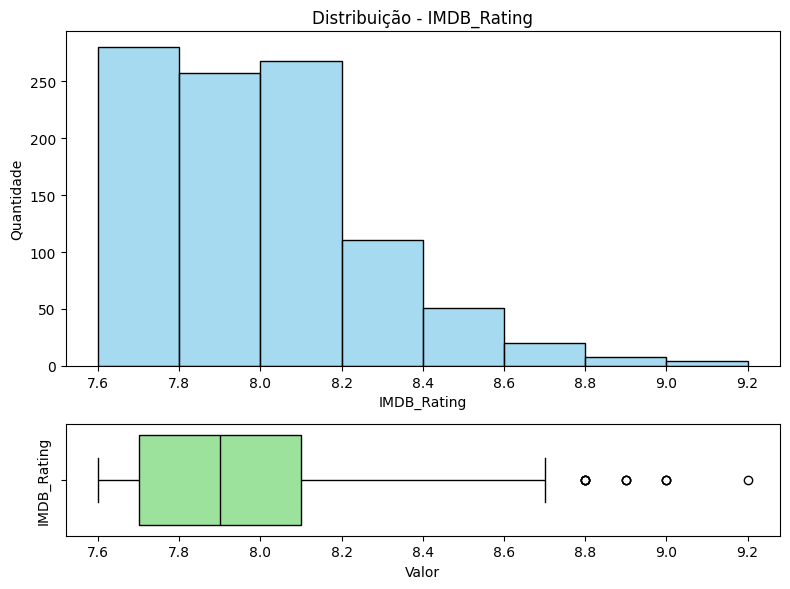

In [47]:

fig, ax = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={"height_ratios": [3, 1]})
sn.histplot(df_imdb["IMDB_Rating"], bins=8, ax=ax[0], color="skyblue")
ax[0].set_ylabel("Quantidade")
ax[0].set_title("Distribuição - IMDB_Rating")
sn.boxplot(x=df_imdb["IMDB_Rating"], ax=ax[1], color="lightgreen", linecolor="black")
ax[1].set_ylabel("IMDB_Rating")
ax[1].set_xlabel("Valor")

plt.tight_layout()
plt.show()

Pela distribuição, podemos ver que a amostra está direcionada a seleção de obras com avaliação entre 7,6 e 9,2, intervalo considerado popularmente como mediano-bom a bom. Há poucos outliers no conjunto.

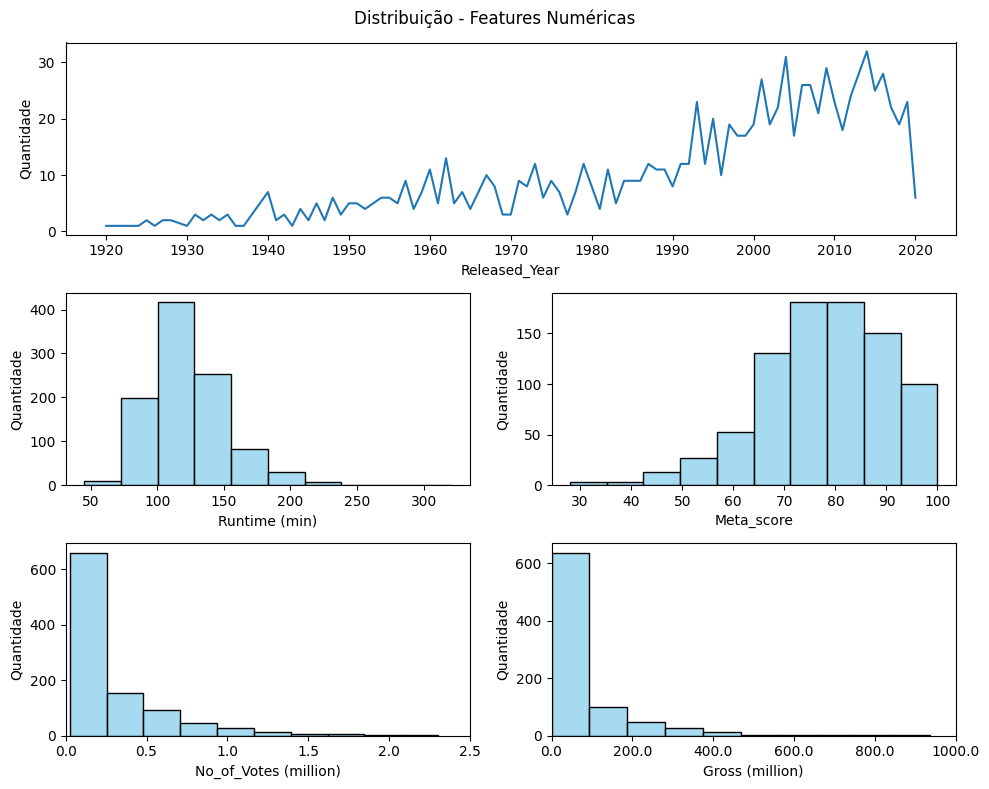

In [237]:
def format_millions(x, pos):
    return f'{x/1e6:.1f}' if x >= 0 else ''

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(3, 2, figure=fig)

ax = fig.add_subplot(gs[0, :])
data = df_imdb.groupby("Released_Year").count()["Series_Title"].reset_index()
sn.lineplot(data=data, x="Released_Year", y="Series_Title", ax=ax)
ax.set_xticks(range(data["Released_Year"].min(), data["Released_Year"].max()+ 1, 10))
ax.set_ylabel("Quantidade")

ax = fig.add_subplot(gs[1,0])
sn.histplot(df_imdb["Runtime"], bins=10, color="skyblue", ax=ax)
ax.set_ylabel("Quantidade")
ax.set_xlabel("Runtime (min)")

ax = fig.add_subplot(gs[1,1])
sn.histplot(df_imdb["Meta_score"], bins=10, color="skyblue", ax=ax)
ax.set_ylabel("Quantidade")

ax = fig.add_subplot(gs[2,0])
sn.histplot(df_imdb["No_of_Votes"], bins=10, color="skyblue", ax=ax)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_millions))
ax.set_xlim(left=0)
ax.set_xticks(ax.get_xticks())
ax.set_xlabel("No_of_Votes (million)")
ax.set_ylabel("Quantidade")

ax = fig.add_subplot(gs[2,1])
sn.histplot(df_imdb["Gross"], bins=10, color="skyblue", ax=ax)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_millions))
ax.set_xlim(left=0)
ax.set_xticks(ax.get_xticks())
ax.set_xlabel("Gross (million)")
ax.set_ylabel("Quantidade")

fig.suptitle("Distribuição - Features Numéricas", y=.98)
fig.tight_layout()


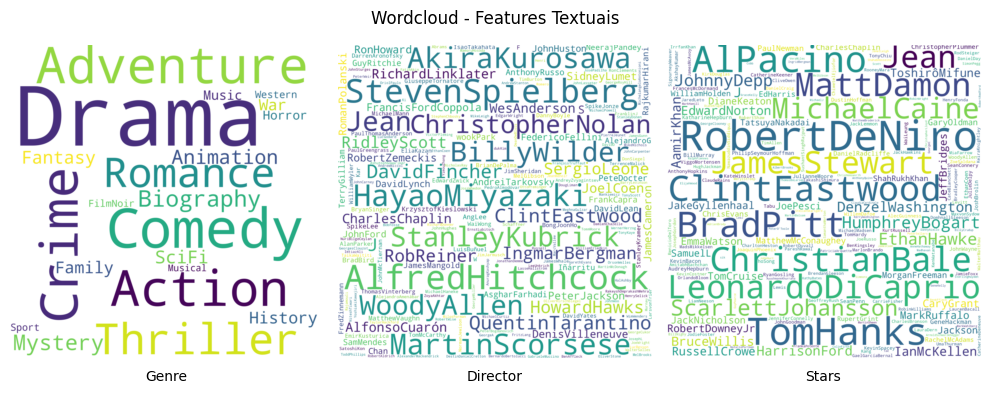

In [157]:
def make_wordcloud(axis, data):
    all_text = " ".join(data.astype(str).tolist()).replace(",", "")
    wordcloud = WordCloud(width=2000, height=2000, background_color='white', collocations=False)
    plot = wordcloud.generate(all_text)
    axis.imshow(plot, interpolation='bilinear')
    axis.axis("off")

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

make_wordcloud(ax[0], df_imdb["Genre"].map(lambda x: x.replace("-", "")))
ax[0].set_title("Genre", y=-0.1, fontsize=10)

director_column = df_imdb["Director"].map(lambda x: x.replace(" ", ""))
make_wordcloud(ax[1], director_column)
ax[1].set_title("Director", y=-0.1, fontsize=10)

cast_column = df_imdb.iloc[:,10:14].map(lambda x: x.replace(" ", ""))
cast_column = [' '.join(map(str, row)) for row in cast_column.values]
make_wordcloud(ax[2], pd.Series(cast_column))
ax[2].set_title("Stars", y=-0.1, fontsize=10)

fig.suptitle("Wordcloud - Features Textuais", y=.85)
fig.tight_layout()

Observando as wordclouds das variaveis textuais, podemos ver que, dentro da amostra, os gêneros mais presentes são os narrativos ficcionais, como Drama, Comédia, Romance, Crime e Aventura. Apesar de se exporem com mais evidência, não representam desabalanceamento exorbitante em relação a grande maioria. <br>
O mesmo pode ser observado entre os diretores e o elenco principal, que possuem nomes famosos em evidencia.

## Análise de Público

A recepção de público pode ser medida dentro da amostra em contextos variados, seja em crítica especializada, nota do público ou em faturamento. Para os grandes estúdios, essa última representa o máximo de importância dentro do lançamento de um projeto, pois confere a possibilidade de retorno do investimento. Sendo assim, considerando essa importância de retorno, vamos avaliar a amostra para descobrir **os fatores relacionados à alta expectativa de faturamento de um filme**.

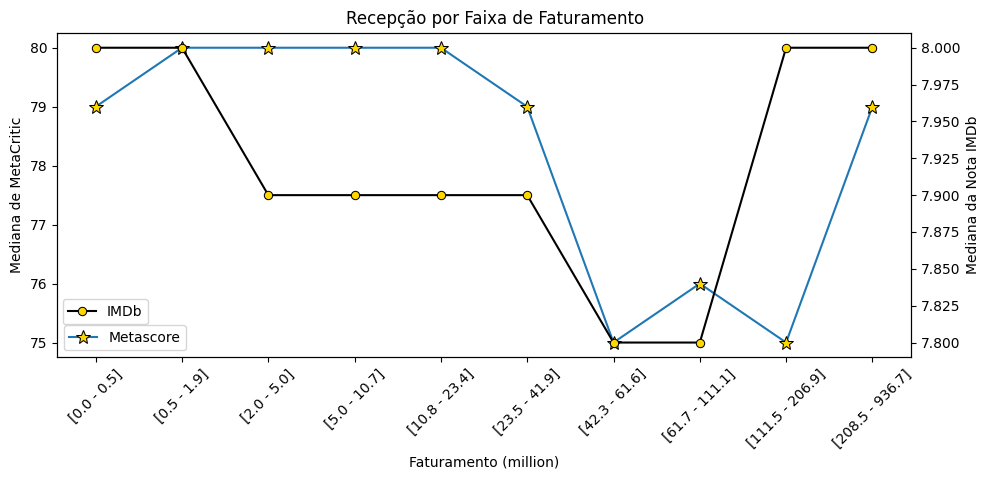

In [ ]:
def info_decil(minq, maxq):
    decil_min = df_imdb["Gross"].quantile(minq)
    decil_max = df_imdb["Gross"].quantile(maxq)
    df_decil = df_imdb[(df_imdb["Gross"] > decil_min) & (df_imdb["Gross"] <= decil_max)]
    gross, meta, imdb = df_decil["Gross"], df_decil["Meta_score"], df_decil["IMDB_Rating"]
    decil = f"[{gross.min()/1e6:.1f} - {gross.max()/1e6:.1f}]"

    return [decil, meta.median(), imdb.median()]

dict_decis = {d : info_decil(((d-1)*0.1), (d*0.1)) for d in range(1,11)}
data = pd.DataFrame.from_dict(dict_decis, orient='index')

fig, ax = plt.subplots(figsize=(10, 5))

sn.lineplot(data=data, y=data[1], 
            x=data[0], 
            ax=ax, marker='*', 
            markerfacecolor='gold', 
            markeredgecolor='black', 
            markersize=10,
            label='Metascore')
ax.set_ylabel("Mediana de MetaCritic")
ax.set_xlabel("Faturamento (million)")
ax.tick_params(axis='x', rotation=45)
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc="lower left")

ax = ax.twinx()
sn.lineplot(data=data, 
            x=data[0], 
            y=data[2], 
            ax=ax, 
            color="black", 
            marker="o", 
            markerfacecolor='gold', 
            markeredgecolor='black',
            label='IMDb')
ax.set_ylabel("Mediana da Nota IMDb")
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, bbox_to_anchor=(.115, 0.2))

fig.suptitle("Recepção por Faixa de Faturamento", y=.95)
fig.tight_layout()

Aqui, podemos notar que, a nota mediana do público geral (IMDb), tem um leve acompanhamento com a nota mediana dos críticos especializados (Metascore), quando se nota o comportamento das curvas. No que tange ao faturamento, é possível observar que existe uma discordância entre a aceitação de filmes com faturamentos mais baixos, enquanto vemos também que, a partir do momento em que um filme ultrapassa o faturamento de 200 milhões, sua mediana de avaliações ascende.<br><br>

Mas o que se passa entre esses três recortes de comportamento das avaliações? Vamos observar outras variáveis:

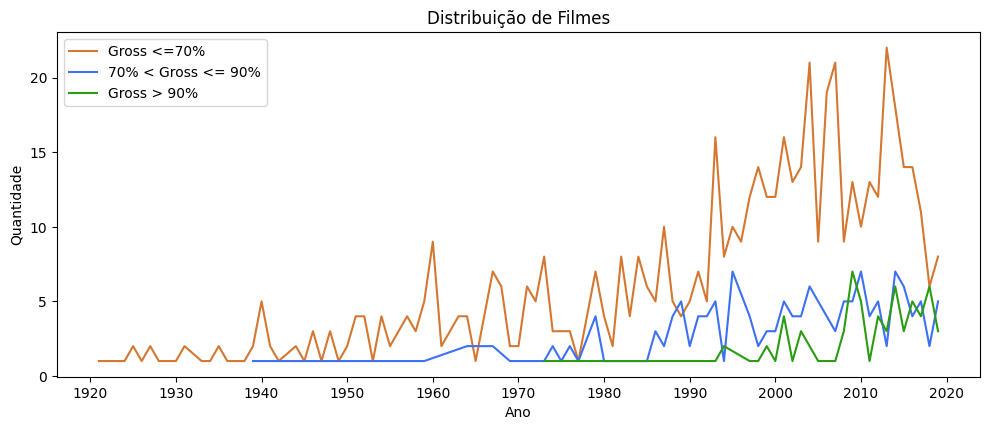

In [ ]:
def group_per_genre(df, col, info):
    list_info = []
    for i in info.keys():
        df_col = df[df["Genre"].str.contains(col, na=False)]
        result = getattr(df_col[i], info[i])()
        list_info.append(result)
    return list_info

def plot_series_time(ax, dc, color, label):
    data = df_imdb[dc].groupby("Released_Year").count()["Series_Title"].reset_index()
    sn.lineplot(data=data, x="Released_Year", y="Series_Title", ax=ax, color=color, label=label)
    ax.set_yticks(range(0, 25, 5))
    ax.set_xticks(range(df_imdb["Released_Year"].min(), df_imdb["Released_Year"].max()+ 1, 10))

dc_70 = df_imdb["Gross"].quantile(0.7)
dc_90 = df_imdb["Gross"].quantile(0.9)

group_1 = (df_imdb["Gross"] <= dc_70)
group_2 = ((df_imdb["Gross"] > dc_70) & (df_imdb["Gross"] <= dc_90))
group_3 = (df_imdb["Gross"] > dc_90)

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 1, figure=fig)

ax = fig.add_subplot(gs[0,0])
plot_series_time(ax, group_1, "#d47731", "Gross <=70%")
plot_series_time(ax, group_2, "#3d70f2", "70% < Gross <= 90%")
plot_series_time(ax, group_3, "#2a9c11", "Gross > 90%")

ax.set_xlabel("Ano")
ax.set_ylabel("Quantidade")
ax.legend()

plt.title("Distribuição de Filmes")
plt.tight_layout()
plt.show()


Nessa distribuição temporal, podemos notar que todos os filmes que possuem faturamento acima de 90% do conjunto iniciam na série temporal a partir dos anos 70. As outras categorias de faixa de faturamento preenchem em maioria a série. Isso denota alguns fatores sobre o mundo do cinema, entre eles o avanço da tecnologia e a democratização do acesso às salas de cinema, a maior possibilidade de divulgação visto os novos meios de comunicação e adaptações dos locais de sessão de cinema. Vale lembrar que todos esses fatores também contribuem para o aumento da distribuição geral de filmes por época. <br>
Ainda considerando a abordagem temporal, é de se observar que, se os filmes com maior faturamento estão exclusivamente presentes nas decadas mais modernas, o recorte temporal pode indicar um fator para a relação entre as avaliações Metascore e IMDb estarem consideravelmente altas nessa faixa de faturamento, uma vez que são registros online.<br><br>

Podemos então esperar parte da influencia de faturamento do recorte temporal do lançamento de um filme, trazendo assim consequencias como moda, tecnologia ou situação econômica.

## Analise Multivariada

Agora que conhecemos os valores mais comuns no conjunto, vamos explorar esses pontos utilizando o senso comum de escolha de um filme. Aqui, podemos levantar o seguinte questionamento: **O que indicar para uma pessoa que não conhecemos?** <br>
Sendo uma icognita seus gostos pessoais, devemos nos ater a fatores que aumentam a probabilidade de aceitação de uma sugestão. Nesse caso os dados de aceitação de um filme. Uma vez que o projeto busca descobrir uma nota vinda do publico para um filme, adotemos então a avaliação do IMDb como um indice de aceitação para um filme.<br>
Quando decidimos o que assistir, é normal considerarmos características da história como gênero do filme, sinopse e participações. Sendo assim, vamos dar uma olhada nos números e comportamento dessas características, e como elas se relacionam com nossa variável alvo.

**Gênero X Bilheteria -> Nota**

Atribuindo titulo de popularidade à bilheteria (Gross) de um filme, vamos começar observando entre os generos disponíveis, onde podemos encontrar os maiorers e menores níveis de popularidade.

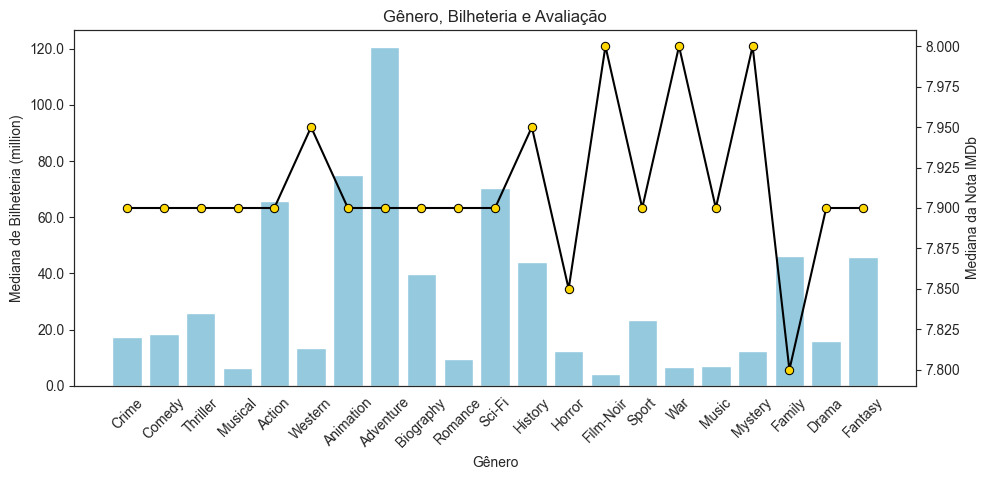

In [541]:
genres = " ".join(df_imdb["Genre"].astype(str).tolist()).replace(",", "").split()
types = {"Gross": "median", "IMDB_Rating": "median"}
dict_genres = {k: group_per_genre(df_imdb, k, types) for k in set(genres)}
data = pd.DataFrame.from_dict(dict_genres, orient='index')

median_gross = df_imdb["Gross"].median()
median_rate = df_imdb["IMDB_Rating"].median()

fig, ax = plt.subplots(figsize=(10, 5))

sn.barplot(data=data, y=data[0], x=data.index, ax=ax, color="skyblue")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_millions))
ax.set_ylabel("Mediana de Bilheteria (million)")
ax.set_xlabel("Gênero")
ax.tick_params(axis='x', rotation=45)

ax = ax.twinx()
sn.lineplot(data=data, 
            x=data.index, 
            y=data[1], 
            ax=ax, 
            color="black", 
            marker="o", 
            markerfacecolor='gold', 
            markeredgecolor='black',)
ax.set_ylabel("Mediana da Nota IMDb")

fig.suptitle("Gênero, Bilheteria e Avaliação", y=.95)
fig.tight_layout()

Adotando um olhar comparativo, podemos notar que os picos de nota mediana não correspondem a faturamentos exorbitantes, como é o caso de War, Film-Noir e Mystery. Considerando o recorte de classificação em nota da amostra e sua amplitude, olhando o contrário da baixa popularidade, temos Adventure, Animation e Sci-Fi com alto faturamento e avaliação mediana, quando generalizada.

### Mas o que levaria alguém a desistir de ver um filme que é considerado bom por quem viu?

Nesse contexto de comportamento comum na escolha de um filme, vamos considerar fatores de conforto para levantarmos hipóteses.<br>
A primeira delas é o **tempo de reprodução**. <br><br>

Vamos verificar como se comporta o tempo de reprodução nos gêneros disponíveis na amostra.

Text(0.5, 1.0, 'Tempo mediano de filme por Gênero')

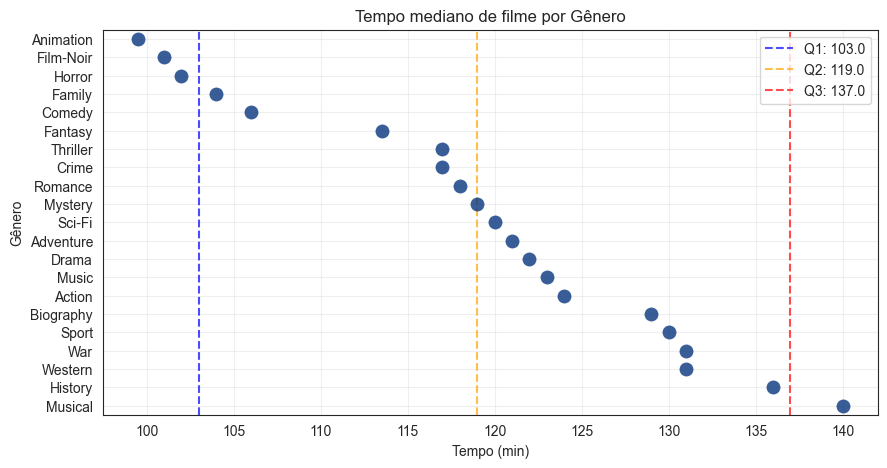

In [629]:
dict_genres = {k: group_per_genre(df_imdb, k, {"Runtime": "median"}) for k in set(genres)}
data = pd.DataFrame.from_dict(dict_genres, orient='index').sort_values(by=0)

plt.subplots(figsize=(10, 5))
sn.stripplot(data=data, 
             y=data.index, 
             x=data[0], 
             size=10,           
             color="#07357d", 
             alpha=0.8,         
             jitter=False,
             edgecolor="black")

mediana = df_imdb["Runtime"].median()
q1 = df_imdb["Runtime"].quantile(0.25)
q3 = df_imdb["Runtime"].quantile(0.75)

plt.axvline(q1, color="blue", linestyle="--", alpha=0.7, label=f"Q1: {q1:.1f}")
plt.axvline(mediana, color="orange", linestyle="--", alpha=0.7, label=f"Q2: {mediana:.1f}")
plt.axvline(q3, color="red", linestyle="--", alpha=0.7, label=f"Q3: {q3:.1f}")
plt.legend()
plt.xlabel("Tempo (min)")
plt.ylabel("Gênero")
plt.grid(axis="y", alpha=0.3)
plt.grid(axis="x", alpha=0.3)

plt.title("Tempo mediano de filme por Gênero")

Ao tentar estabelecer uma relação entre o tempo de filme e a recepção do público (em popularidade medida pelo faturamento e em avaliações do IMDb), percebemos que não existe relação direta.<br>
No caso dos gêneros mais populares (Adventure, Animation, Sci-Fi) a avaliação do público está proximo da mediana, e o tempo de exibição traz uma faixa da mediana para baixo. <br>
Considerando os gêneros mais bem aceitos em avaliação (Film-Noir, Mistery, War), temos a mediana dos três está variada entre duração curta, média e longa, o que indica que o tempo de filme não deve ter impacto na qualidade, para os que avaliam.<br>
Agora, quando observamos os 3 gêneros mais longos (War, History, Musical), encontramos apenas um deles acima da mediana de popularidade, porém ainda avaliam bem.<br>
Já com os 3 gêneros mais curtos (Animation, Film-Noir, Horror), temos uma popularidade com medianas mais abaixo e uma avaliação variada.<br><br>

Com isso, podemos inferir que o tempo de duração de um filme não afeta na percepção de qualidade para os avaliadores, mas pode ter alguma influência na popularidade quando o filme é mais longo, pois grande parte dos que estão à direita da mediana de tempo, apresentam faturamento abaixo da mediana total ou abaixo em relação a todos os gêneros.


O segundo possível fator de interesse pode ser **a sinopse**.<br><br>

Considerando que sinopses similares tendem a atrair públicos similares, será que conseguimos encontrar semelhança no enredo dos filmes mais populares da amostra?

No conjunto de dados, temos uma feature chamada Overview, que traz em um texto curto informações sobre o enredo do filme. Sendo uma tipo de dado não estruturado e de difícil quantificação, a ideia será codificar esse texto e verificar os filmes que possuem o texto mais similar a esse.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\glaup\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


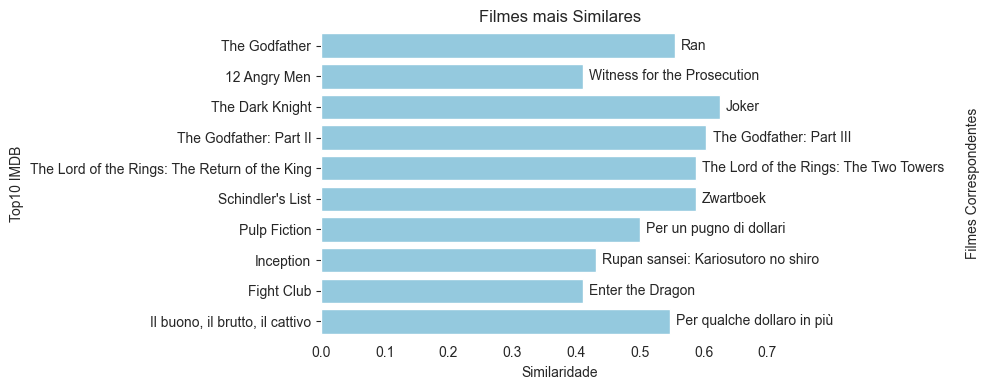

In [ ]:
def cleanning_text(text):
    text = text.lower()
    text = re.compile(r"[-+]?[.\d]*\d+[-:,./\d]*").sub(r'', text)
    text = text.replace("'s", "")
    text = text.replace("-", " ")
    stops = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stops and len(word) >= 3])
    return text

def max_IMDB(array, axis=1):
    list_sims, list_index = [], []
    
    for i in range(array.shape[0]):
        linha = array[i]
        index_top2 = np.argpartition(linha, -2)[-2:]
        sim_top2 = linha[index_top2]
        sim = sim_top2[np.argsort(sim_top2)[-2]]
        index = index_top2[np.argsort(sim_top2)[-2]]
        
        list_sims.append(sim)
        list_index.append(index)
    
    return np.array(list_sims), np.array(list_index)

nltk.download('stopwords')

film_overview = df_imdb["Overview"].map(lambda x: cleanning_text(x))
embeddings = SentenceTransformer('all-MiniLM-L6-v2').encode(film_overview)

top_10_imdb = df_imdb.sort_values(by="IMDB_Rating", ascending=False).head(10).index
similarity_top_10 = cosine_similarity(embeddings)[top_10_imdb]
similarities, indexes = max_IMDB(similarity_top_10)
film_names = df_imdb.iloc[top_10_imdb,1]
sim_names = df_imdb.iloc[indexes,1]

data = pd.DataFrame(dict(zip(["Top10 IMDB","Similaridade"], [film_names, similarities])))

fig, ax = plt.subplots(figsize=(10, 4))

sn.barplot(data=data, y="Top10 IMDB", x="Similaridade", ax=ax, color="skyblue")
ax.grid(False, axis="both")
ax.set_xlabel("Similaridade")
for spine in ax.spines.values():
    spine.set_visible(False)

for i, (similarity, film) in enumerate(zip(similarities, sim_names)):
    ax.text(similarity + 0.01, i, film, ha='left', va='center')
ax.set_xlim(0, max(similarities) * 1.2)

ax2 = ax.twinx()
ax2.grid(False, axis="both")
ax2.set_ylabel("Filmes Correspondentes", labelpad=120)
ax2.set_yticks([])
for spine in ax2.spines.values():
    spine.set_visible(False)

plt.title("Filmes mais Similares")
plt.tight_layout()
plt.show()


Será que esses filmes conseguem atrair alguma atenção de crítica e de popularidade tal qual seus similares?

C:\Users\glaup\AppData\Local\Temp\ipykernel_15024\1680115656.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)
C:\Users\glaup\AppData\Local\Temp\ipykernel_15024\1680115656.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)


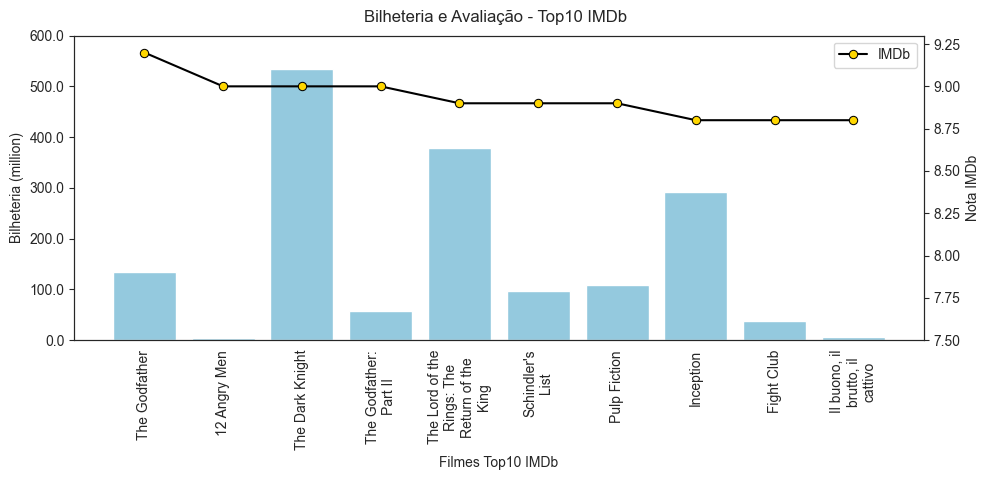

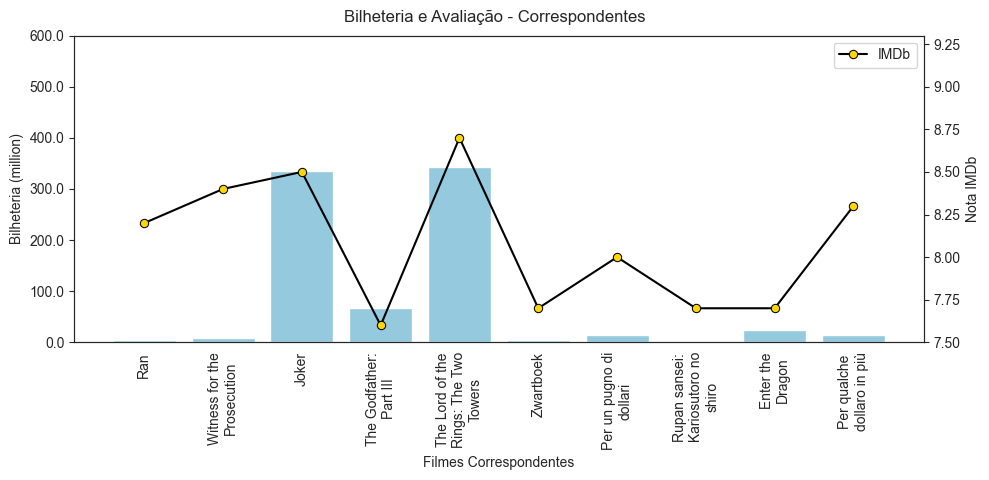

In [569]:
def plot_similar_films(index, label):
    data = df_imdb.iloc[index,:][["Gross", "Series_Title", "IMDB_Rating"]]
    data.set_index("Series_Title", inplace=True)
    fig, ax = plt.subplots(figsize=(10, 5))

    sn.barplot(data=data, y="Gross", x=data.index, ax=ax, color="skyblue")
    ax.set_ylim(0, 600000000)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_millions))
    ax.set_ylabel("Bilheteria (million)")
    ax.set_xlabel(f"Filmes {label}")
    ax.tick_params(axis='x', rotation=45)

    labels = [textwrap.fill(label, width=15) for label in data.index]
    ax.set_xticklabels(labels, rotation=90)

    ax = ax.twinx()
    sn.lineplot(data=data, 
                x=data.index, 
                y="IMDB_Rating", 
                ax=ax, 
                color="black", 
                marker="o", 
                markerfacecolor='gold', 
                markeredgecolor='black',
                label="IMDb")
    ax.set_ylabel("Nota IMDb")
    ax.set_ylim(7.5, 9.3)

    fig.suptitle(f"Bilheteria e Avaliação - {label}", y=.95)
    fig.tight_layout()

plot_similar_films(top_10_imdb, "Top10 IMDb")
plot_similar_films(indexes, "Correspondentes")


Observando os números comparativos entre os filmes correspondentes e os melhores avaliados no IMBb, vemos que a diferença na avaliação é notável, com os correspondentes permanecendo em média proximo às faixas medianas de nota. Quando focamos na bilheteria, podemos ver que os filmes do Top10 sobressaem em maior parte dos casos, além de ser possível notar uma semelhança na curva dos dados, devido à presença de filmes pertencentes a uma franquia, e, por isso serem semelhantes. Consequentemente, por serem continuações atraem o público.<br>
Podemos ver também que existem casos em que a bilheteria foi maior do que a nota, mesmo os filmes sendo parte de franquias.

**Dada as similaridades apresentadas, será que, por inferência, conseguimos descobrir se há semelhança nos gêneros pela sinopse?**

Usando um modelo de rede neural simples treinado com a amostra, vamos observar os resultados para essa pergunta: 

In [621]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

def get_genre_pred(predicted, threshold = 0.4):
    genres_result = []
    for c, gen in enumerate(mlb.classes_):
        if predicted[c] >= threshold:
            genres_result.append((gen, f"{float(predicted[c])*100:.1f}%"))

    return genres_result


list_genre = df_imdb["Genre"].map(lambda x: [g.strip() for g in x.split(",")])
mlb = MultiLabelBinarizer()
mlb.fit(list_genre)
data = pd.DataFrame(mlb.fit_transform(list_genre), 
                   columns=[g for g in mlb.classes_],
                   index=df_imdb.index)

index_data = np.array(list(set(data.index.values)-set(top_10_imdb)-set(indexes)))

model = OneVsRestClassifier(LogisticRegression(max_iter=1000))
X_train = embeddings[index_data]
y_train = data.values[index_data]
model.fit(X_train, y_train)

X_data, y_data = embeddings[top_10_imdb], data.values[top_10_imdb]
X_corr, y_corr = embeddings[indexes], data.values[indexes]

pred_data = model.predict_proba(X_data)
pred_corr = model.predict_proba(X_corr)

In [624]:
print("Predição Top10 IMDb:")
for i in range(10):
    film = df_imdb.loc[top_10_imdb[i]]["Series_Title"]
    print(f"{film} - {get_genre_pred(pred_data[i])}")

print("\n\nPredição Filmes Correspondentes:")
for i in range(10):
    film = df_imdb.loc[indexes[i]]["Series_Title"]
    print(f"{film} - {get_genre_pred(pred_corr[i])}")

Predição Top10 IMDb:
The Godfather - [('Action', '48.5%'), ('Crime', '54.3%'), ('Drama', '75.1%')]
12 Angry Men - [('Drama', '90.0%')]
The Dark Knight - [('Action', '57.0%'), ('Drama', '44.1%')]
The Godfather: Part II - [('Crime', '53.2%'), ('Drama', '76.0%')]
The Lord of the Rings: The Return of the King - [('Action', '49.0%'), ('Adventure', '54.9%'), ('Drama', '59.8%')]
Schindler's List - [('Drama', '83.9%')]
Pulp Fiction - [('Crime', '66.2%'), ('Drama', '66.4%')]
Inception - [('Drama', '61.4%')]
Fight Club - [('Comedy', '43.9%'), ('Drama', '45.0%')]
Il buono, il brutto, il cattivo - [('Crime', '49.5%'), ('Drama', '47.7%')]


Predição Filmes Correspondentes:
Ran - [('Action', '70.8%'), ('Adventure', '43.4%'), ('Drama', '65.2%')]
Witness for the Prosecution - [('Drama', '88.8%')]
Joker - [('Crime', '49.1%'), ('Drama', '58.4%')]
The Godfather: Part III - [('Crime', '47.3%'), ('Drama', '65.9%')]
The Lord of the Rings: The Two Towers - [('Action', '41.2%'), ('Adventure', '64.1%'), ('Dram

Assim, uma vez inferido o gênero baseado em sua sinopse, e considerando o grau de popularidade tomando como métrica a bilheteria, **o que recomendar a quem não se sabe nada?**

- Sinopse e Gênero focados em Aventura
- Com menos de 130min de duração
- Lançamento a partir dos anos 2000